# Eksperimen Machine Learning - Ethereum Fraud Detection
### Mohammad Ari Alexander Aziz

## Tujuan Eksperimen
Notebook ini berisi eksperimen lengkap untuk deteksi fraud pada transaksi Ethereum, meliputi:
1. Data Loading
2. Exploratory Data Analysis (EDA)
3. Data Preprocessing
4. Model Building & Evaluation

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    roc_auc_score, 
    roc_curve, 
    auc,
    ConfusionMatrixDisplay
)
import pickle

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Data Loading

Dataset berisi transaksi Ethereum dengan label fraud (FLAG=1) dan non-fraud (FLAG=0).

In [2]:
# Load dataset
df = pd.read_csv('../transaction_dataset.csv', index_col=0)
print(f"Dataset shape: {df.shape}")
print(f"\nDataset info:")
print(df.info())
df.head()

Dataset shape: (9841, 50)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 9841 entries, 0 to 9840
Data columns (total 50 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Index                                                 9841 non-null   int64  
 1   Address                                               9841 non-null   object 
 2   FLAG                                                  9841 non-null   int64  
 3   Avg min between sent tnx                              9841 non-null   float64
 4   Avg min between received tnx                          9841 non-null   float64
 5   Time Diff between first and last (Mins)               9841 non-null   float64
 6   Sent tnx                                              9841 non-null   int64  
 7   Received Tnx                                          9841 non-null   int64  
 8   Number of Created Cont

,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


## 3. Exploratory Data Analysis (EDA)

### 3.1 Dataset Overview

In [3]:
# Remove Index and Address columns (not needed for modeling)
df = df.iloc[:, 2:]
print(f"Shape after removing Index and Address: {df.shape}")
df.head()

Shape after removing Index and Address: (9841, 48)


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


### 3.2 Target Distribution Analysis

Target Distribution:
FLAG
0    7662
1    2179
Name: count, dtype: int64

Fraud percentage: 22.14%


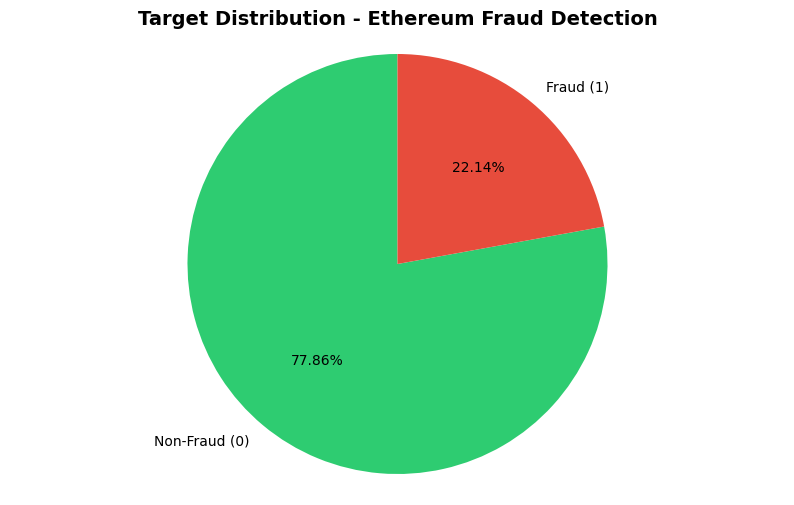


Observation: Dataset is imbalanced, SMOTE will be used later.


In [4]:
# Analyze target distribution
print("Target Distribution:")
print(df['FLAG'].value_counts())
print(f"\nFraud percentage: {df['FLAG'].mean() * 100:.2f}%")

# Visualize target distribution
fig, ax = plt.subplots(figsize=(10, 6))
labels = ['Non-Fraud (0)', 'Fraud (1)']
colors = ['#2ecc71', '#e74c3c']
counts = df['FLAG'].value_counts()

plt.pie(counts, labels=labels, autopct='%1.2f%%', colors=colors, startangle=90)
plt.title('Target Distribution - Ethereum Fraud Detection', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()

print("\nObservation: Dataset is imbalanced, SMOTE will be used later.")

### 3.3 Missing Values Analysis

Features with Missing Values:
                                     Missing Count  Percentage
ERC20 most sent token type                    2697   27.405751
ERC20_most_rec_token_type                      871    8.850727
ERC20 total ether sent                         829    8.423941
ERC20 total Ether received                     829    8.423941
ERC20 uniq sent addr                           829    8.423941
ERC20 uniq rec addr                            829    8.423941
ERC20 uniq sent addr.1                         829    8.423941
ERC20 total Ether sent contract                829    8.423941
Total ERC20 tnxs                               829    8.423941
ERC20 avg time between sent tnx                829    8.423941
ERC20 uniq rec contract addr                   829    8.423941
ERC20 avg time between rec tnx                 829    8.423941
ERC20 avg time between rec 2 tnx               829    8.423941
ERC20 max val rec                              829    8.423941
ERC20 avg val rec        

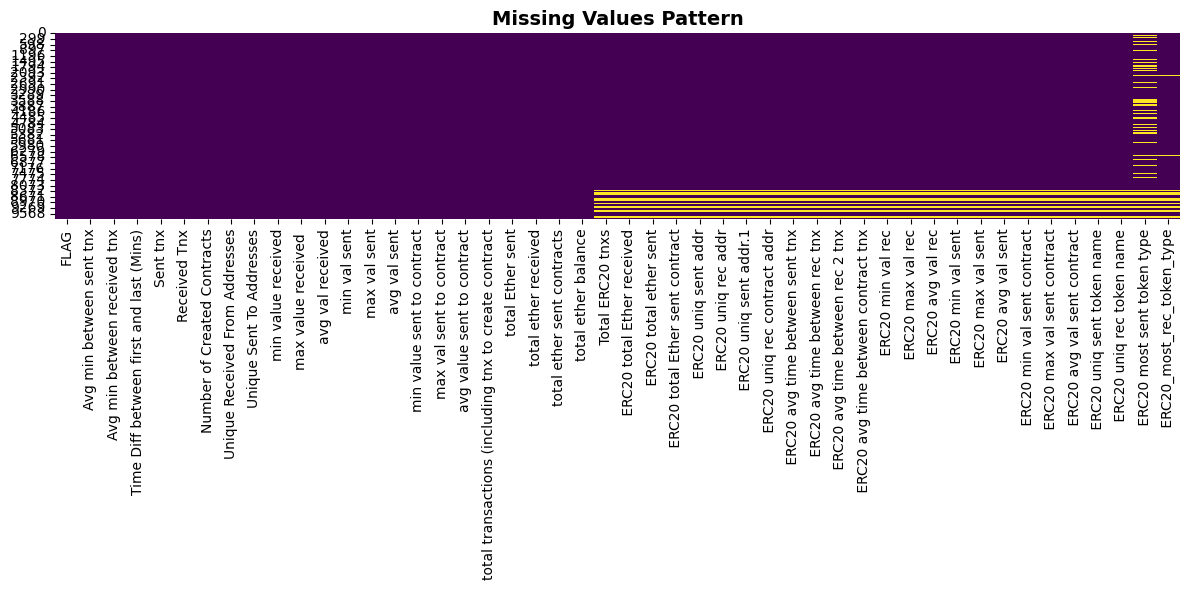

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("Features with Missing Values:")
print(missing_df)

# Visualize missing values pattern
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Pattern', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.4 Statistical Summary

In [6]:
# Statistical summary of numerical features
print("Statistical Summary:")
df.describe().T

Statistical Summary:


,count,mean,std,min,25%,50%,75%,max
FLAG,9841.0,2.214206e-01,4.152241e-01,0.00,0.000000,0.000000e+00,0.000000,1.000000e+00
Avg min between sent tnx,9841.0,5.086879e+03,2.148655e+04,0.00,0.000000,1.734000e+01,565.470000,4.302877e+05
Avg min between received tnx,9841.0,8.004851e+03,2.308171e+04,0.00,0.000000,5.097700e+02,5480.390000,4.821755e+05
Time Diff between first and last (Mins),9841.0,2.183333e+05,3.229379e+05,0.00,316.930000,4.663703e+04,304070.980000,1.954861e+06
Sent tnx,9841.0,1.159317e+02,7.572264e+02,0.00,1.000000,3.000000e+00,11.000000,1.000000e+04
Received Tnx,9841.0,1.637009e+02,9.408366e+02,0.00,1.000000,4.000000e+00,27.000000,1.000000e+04
Number of Created Contracts,9841.0,3.729702e+00,1.414456e+02,0.00,0.000000,0.000000e+00,0.000000,9.995000e+03
Unique Received From Addresses,9841.0,3.036094e+01,2.986211e+02,0.00,1.000000,2.000000e+00,5.000000,9.999000e+03
Unique Sent To Addresses,9841.0,2.584016e+01,2.638204e+02,0.00,1.000000,2.000000e+00,3.000000,9.287000e+03
min value received,9841.0,4.384515e+01,3.259291e+02,0.00,0.001000,9.585600e-02,2.000000,1.000000e+04


### 3.5 Feature Variance Analysis

In [7]:
# Check for zero variance features
numericals = df.select_dtypes(include=['float64', 'int64']).columns
variance = df[numericals].var()
zero_var_features = variance[variance == 0]

print("Features with Zero Variance:")
print(zero_var_features)
print(f"\nTotal features with zero variance: {len(zero_var_features)}")

Features with Zero Variance:
ERC20 avg time between sent tnx        0.0
ERC20 avg time between rec tnx         0.0
ERC20 avg time between rec 2 tnx       0.0
ERC20 avg time between contract tnx    0.0
ERC20 min val sent contract            0.0
ERC20 max val sent contract            0.0
ERC20 avg val sent contract            0.0
dtype: float64

Total features with zero variance: 7


### 3.6 Correlation Analysis

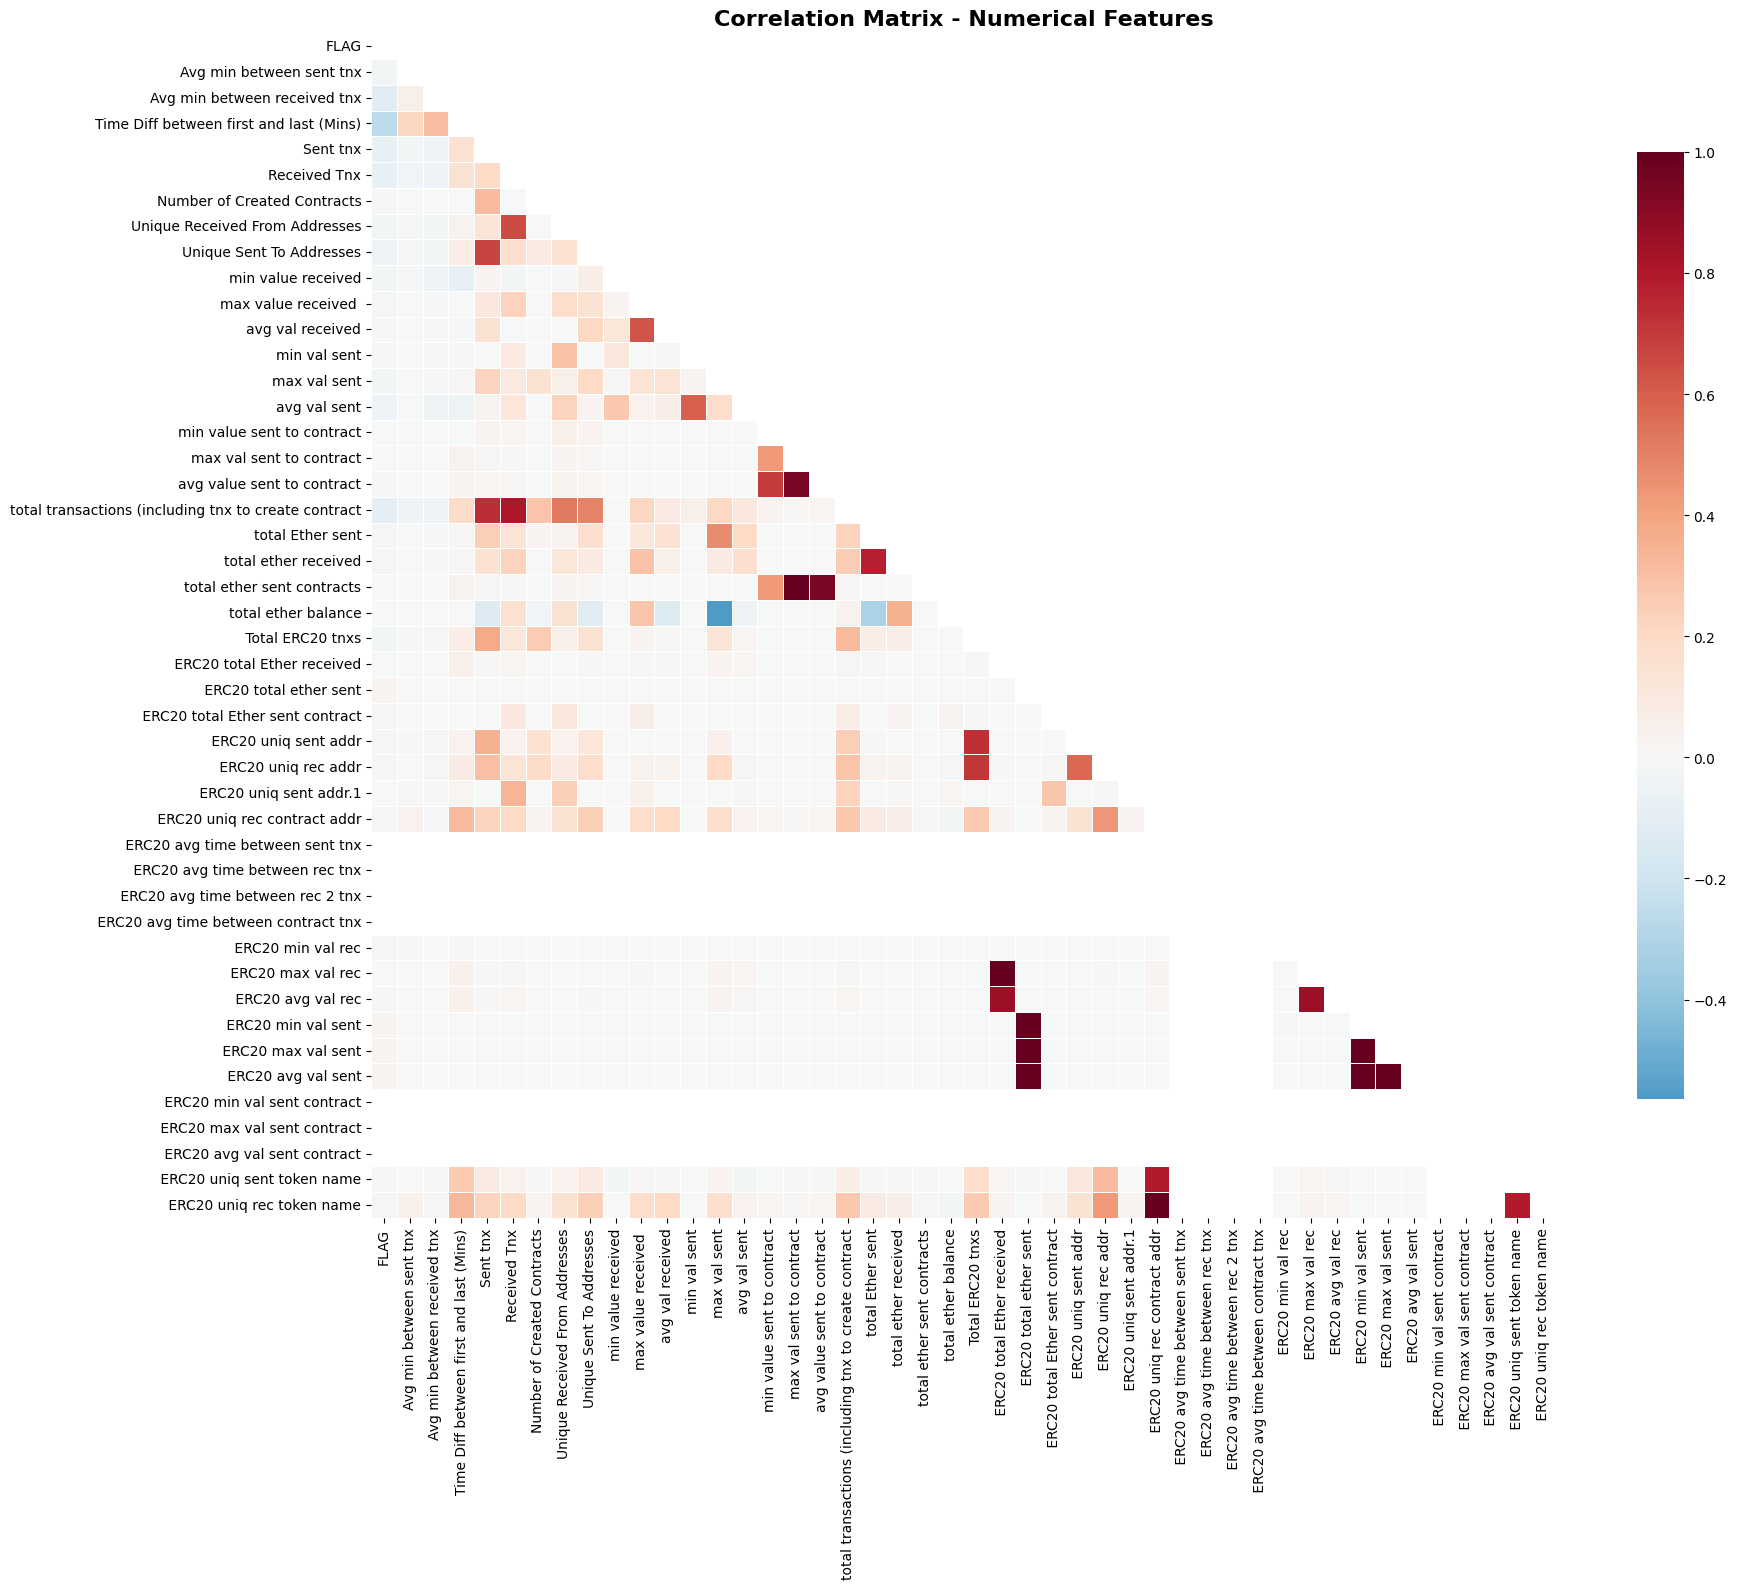


Highly Correlated Feature Pairs (|correlation| > 0.9):
max val sent to contract <-> avg value sent to contract: 0.950
max val sent to contract <-> total ether sent contracts: 1.000
avg value sent to contract <-> total ether sent contracts: 0.950
 ERC20 total Ether received <->  ERC20 max val rec: 1.000
 ERC20 total ether sent <->  ERC20 min val sent: 0.999
 ERC20 total ether sent <->  ERC20 max val sent: 1.000
 ERC20 total ether sent <->  ERC20 avg val sent: 1.000
 ERC20 uniq rec contract addr <->  ERC20 uniq rec token name: 1.000
 ERC20 min val sent <->  ERC20 max val sent: 1.000
 ERC20 min val sent <->  ERC20 avg val sent: 1.000
 ERC20 max val sent <->  ERC20 avg val sent: 1.000


In [8]:
# Correlation matrix for numerical features
plt.figure(figsize=(20, 16))
corr = df[numericals].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated features (>0.9)
high_corr = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > 0.9:
            high_corr.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))

print(f"\nHighly Correlated Feature Pairs (|correlation| > 0.9):")
for feat1, feat2, corr_val in high_corr:
    print(f"{feat1} <-> {feat2}: {corr_val:.3f}")

### 3.7 Feature Distribution Analysis

In [9]:
# Analyze categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"Categorical columns: {list(categorical_cols)}")

for col in categorical_cols:
    print(f"\n{col} - Unique values: {df[col].nunique()}")
    print(df[col].value_counts().head(10))

Categorical columns: [' ERC20 most sent token type', ' ERC20_most_rec_token_type']

 ERC20 most sent token type - Unique values: 304
 ERC20 most sent token type
0                                4399
                                 1191
EOS                               138
OmiseGO                           137
Golem                             130
blockwell.ai KYC Casper Token     128
StatusNetwork                      61
BAT                                38
Qtum                               34
Bancor                             32
Name: count, dtype: int64

 ERC20_most_rec_token_type - Unique values: 466
 ERC20_most_rec_token_type
0                        4399
OmiseGO                   873
Blockwell say NOTSAFU     779
DATAcoin                  358
Livepeer Token            207
EOS                       161
XENON                     145
Golem                     126
GSENetwork                 80
Tronix                     76
Name: count, dtype: int64


## 4. Data Preprocessing

### 4.1 Handle Categorical Features

In [10]:
# Drop categorical features (too many unique values, not suitable for modeling)
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
print(f"Dropping categorical features: {categorical_features}")
df = df.drop(categorical_features, axis=1)
print(f"\nShape after dropping categorical features: {df.shape}")

Dropping categorical features: [' ERC20 most sent token type', ' ERC20_most_rec_token_type']

Shape after dropping categorical features: (9841, 46)


### 4.2 Handle Missing Values

In [11]:
# Fill missing values with median
print("Filling missing values with median...")
df = df.fillna(df.median())

# Verify no missing values remain
print(f"\nMissing values after imputation: {df.isnull().sum().sum()}")
print(f"Shape: {df.shape}")

Filling missing values with median...

Missing values after imputation: 0
Shape: (9841, 46)


### 4.3 Remove Zero Variance Features

In [12]:
# Remove features with zero variance
zero_var_cols = df.var()[df.var() == 0].index.tolist()
print(f"Removing {len(zero_var_cols)} zero variance features:")
print(zero_var_cols)

df = df.drop(zero_var_cols, axis=1)
print(f"\nShape after removing zero variance features: {df.shape}")

Removing 7 zero variance features:
[' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']

Shape after removing zero variance features: (9841, 39)


### 4.4 Remove Highly Correlated Features

In [13]:
# Drop highly correlated features to reduce multicollinearity
drop_features = [
    'total transactions (including tnx to create contract',
    'total ether sent contracts',
    'max val sent to contract',
    ' ERC20 avg val rec',
    ' ERC20 max val rec',
    ' ERC20 min val rec',
    ' ERC20 uniq rec contract addr',
    'max val sent',
    ' ERC20 avg val sent',
    ' ERC20 min val sent',
    ' ERC20 max val sent',
    ' Total ERC20 tnxs',
    'avg value sent to contract',
    'Unique Sent To Addresses',
    'Unique Received From Addresses',
    'total ether received',
    ' ERC20 uniq sent token name',
    'min value received',
    'min val sent',
    ' ERC20 uniq rec addr'
]

# Only drop features that exist in the dataframe
existing_drop_features = [f for f in drop_features if f in df.columns]
print(f"Dropping {len(existing_drop_features)} highly correlated features")

df = df.drop(existing_drop_features, axis=1)
print(f"\nShape after removing correlated features: {df.shape}")
print(f"Remaining features: {list(df.columns)}")

Dropping 20 highly correlated features

Shape after removing correlated features: (9841, 19)
Remaining features: ['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'max value received ', 'avg val received', 'avg val sent', 'min value sent to contract', 'total Ether sent', 'total ether balance', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec token name']


### 4.5 Remove Low-Information Features

In [14]:
# Check for features with very low unique values
for col in df.columns:
    if col != 'FLAG':
        unique_count = df[col].nunique()
        if unique_count < 10:
            print(f"\n{col}: {unique_count} unique values")
            print(df[col].value_counts())

# Drop features with mostly zeros
low_info_features = ['min value sent to contract', ' ERC20 uniq sent addr.1']
existing_low_info = [f for f in low_info_features if f in df.columns]
if existing_low_info:
    print(f"\nDropping low-information features: {existing_low_info}")
    df = df.drop(existing_low_info, axis=1)

print(f"\nFinal shape after preprocessing: {df.shape}")
print(f"Final features: {list(df.columns)}")


min value sent to contract: 3 unique values
min value sent to contract
0.00    9839
0.02       1
0.01       1
Name: count, dtype: int64

 ERC20 uniq sent addr.1: 4 unique values
 ERC20 uniq sent addr.1
0.0    9813
1.0      26
3.0       1
2.0       1
Name: count, dtype: int64

Dropping low-information features: ['min value sent to contract', ' ERC20 uniq sent addr.1']

Final shape after preprocessing: (9841, 17)
Final features: ['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'max value received ', 'avg val received', 'avg val sent', 'total Ether sent', 'total ether balance', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec token name']


### 4.6 Save Preprocessed Data

In [15]:
# Save preprocessed data
output_path = 'ethereum_fraud_preprocessing.csv'
df.to_csv(output_path, index=False)
print(f"Preprocessed data saved to: {output_path}")
print(f"Final dataset shape: {df.shape}")

Preprocessed data saved to: ethereum_fraud_preprocessing.csv
Final dataset shape: (9841, 17)


## 5. Data Preparation for Modeling

### 5.1 Split Features and Target

In [17]:
# Separate features and target
X = df.drop('FLAG', axis=1)
y = df['FLAG']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())

Features shape: (9841, 16)
Target shape: (9841,)

Target distribution:
FLAG
0    7662
1    2179
Name: count, dtype: int64


### 5.2 Train-Test Split

In [18]:
# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())

Training set: (7872, 16)
Test set: (1969, 16)

Training target distribution:
FLAG
0    6129
1    1743
Name: count, dtype: int64

Test target distribution:
FLAG
0    1533
1     436
Name: count, dtype: int64


### 5.3 Feature Scaling

In [19]:
# Apply PowerTransformer to normalize features
scaler = PowerTransformer()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using PowerTransformer")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

# Save the scaler for later use
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("\nScaler saved to: scaler.pkl")

Features scaled using PowerTransformer
Scaled training set shape: (7872, 16)
Scaled test set shape: (1969, 16)

Scaler saved to: scaler.pkl


### 5.4 Handle Class Imbalance with SMOTE

Before SMOTE:
Training set shape: (7872, 16)
Target distribution:
FLAG
0    6129
1    1743
Name: count, dtype: int64

After SMOTE:
Training set shape: (12258, 16)
Target distribution:
FLAG
0    6129
1    6129
Name: count, dtype: int64


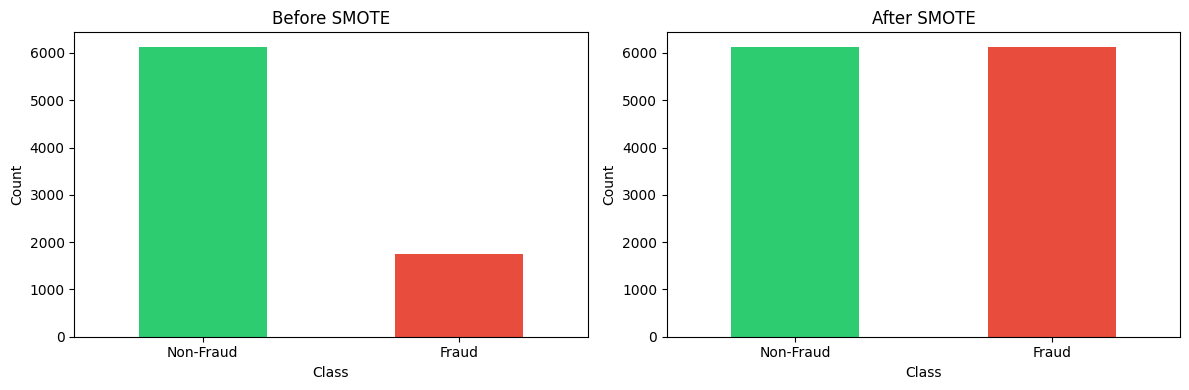

In [20]:
# Apply SMOTE to handle class imbalance
print("Before SMOTE:")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Target distribution:\n{y_train.value_counts()}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE:")
print(f"Training set shape: {X_train_resampled.shape}")
print(f"Target distribution:\n{pd.Series(y_train_resampled).value_counts()}")

# Visualize the effect of SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

y_train.value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Before SMOTE')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)

pd.Series(y_train_resampled).value_counts().plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('After SMOTE')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)

plt.tight_layout()
plt.show()

## 6. Model Building and Evaluation

### 6.1 Logistic Regression

Training Logistic Regression...

Logistic Regression Results:
              precision    recall  f1-score   support

   Non-Fraud       0.96      0.90      0.93      1533
       Fraud       0.71      0.87      0.78       436

    accuracy                           0.89      1969
   macro avg       0.84      0.89      0.86      1969
weighted avg       0.91      0.89      0.90      1969



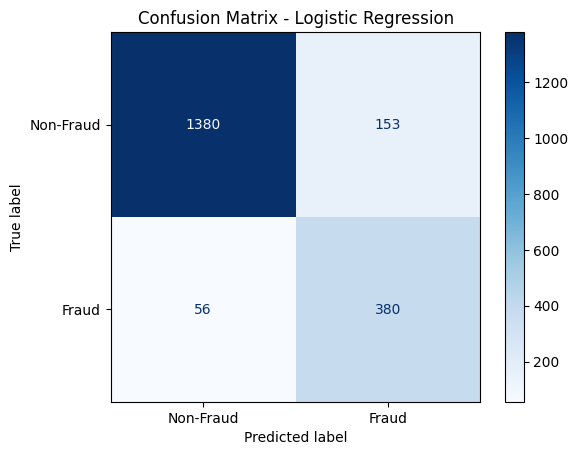

In [21]:
# Train Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluation
print("\nLogistic Regression Results:")
print("=" * 50)
print(classification_report(y_test, y_pred_lr, target_names=['Non-Fraud', 'Fraud']))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

### 6.2 Random Forest Classifier

Training Random Forest...

Random Forest Results:
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.99      0.98      1533
       Fraud       0.96      0.93      0.94       436

    accuracy                           0.98      1969
   macro avg       0.97      0.96      0.96      1969
weighted avg       0.97      0.98      0.97      1969



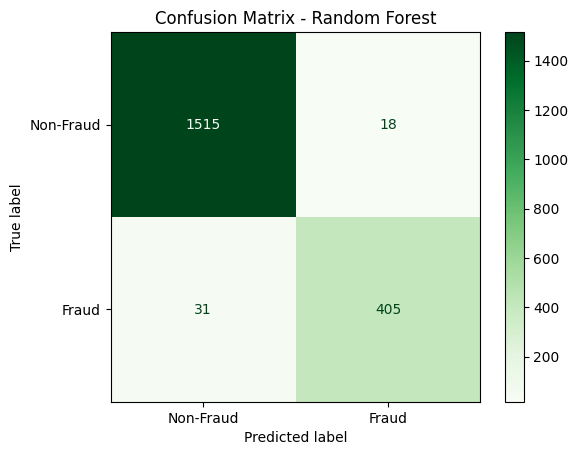

In [22]:
# Train Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluation
print("\nRandom Forest Results:")
print("=" * 50)
print(classification_report(y_test, y_pred_rf, target_names=['Non-Fraud', 'Fraud']))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.show()

### 6.3 XGBoost Classifier

Training XGBoost...

XGBoost Results:
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.99      0.99      1533
       Fraud       0.96      0.94      0.95       436

    accuracy                           0.98      1969
   macro avg       0.97      0.96      0.97      1969
weighted avg       0.98      0.98      0.98      1969



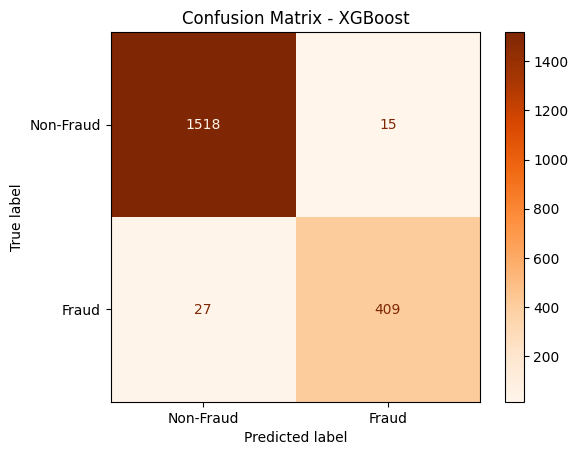

In [23]:
# Train XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluation
print("\nXGBoost Results:")
print("=" * 50)
print(classification_report(y_test, y_pred_xgb, target_names=['Non-Fraud', 'Fraud']))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap='Oranges')
plt.title('Confusion Matrix - XGBoost')
plt.show()

### 6.4 Model Comparison


Model Comparison:
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.893855   0.712946 0.871560  0.784314
      Random Forest  0.975114   0.957447 0.928899  0.942957
            XGBoost  0.978669   0.964623 0.938073  0.951163


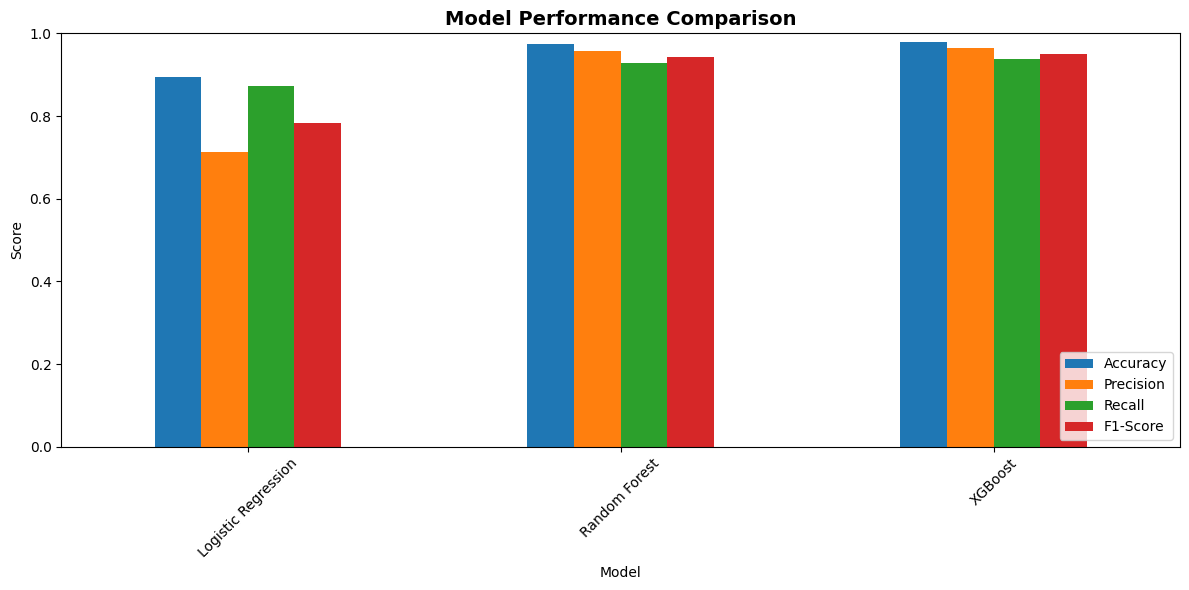


Best Model: XGBoost (F1-Score: 0.9512)


In [24]:
# Compare models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    'Logistic Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb
}

results = []
for model_name, predictions in models.items():
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print("=" * 80)
print(results_df.to_string(index=False))

# Visualize comparison
results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify best model
best_model_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
print(f"\nBest Model: {best_model_name} (F1-Score: {results_df.loc[best_model_idx, 'F1-Score']:.4f})")

### 6.5 ROC Curve Analysis

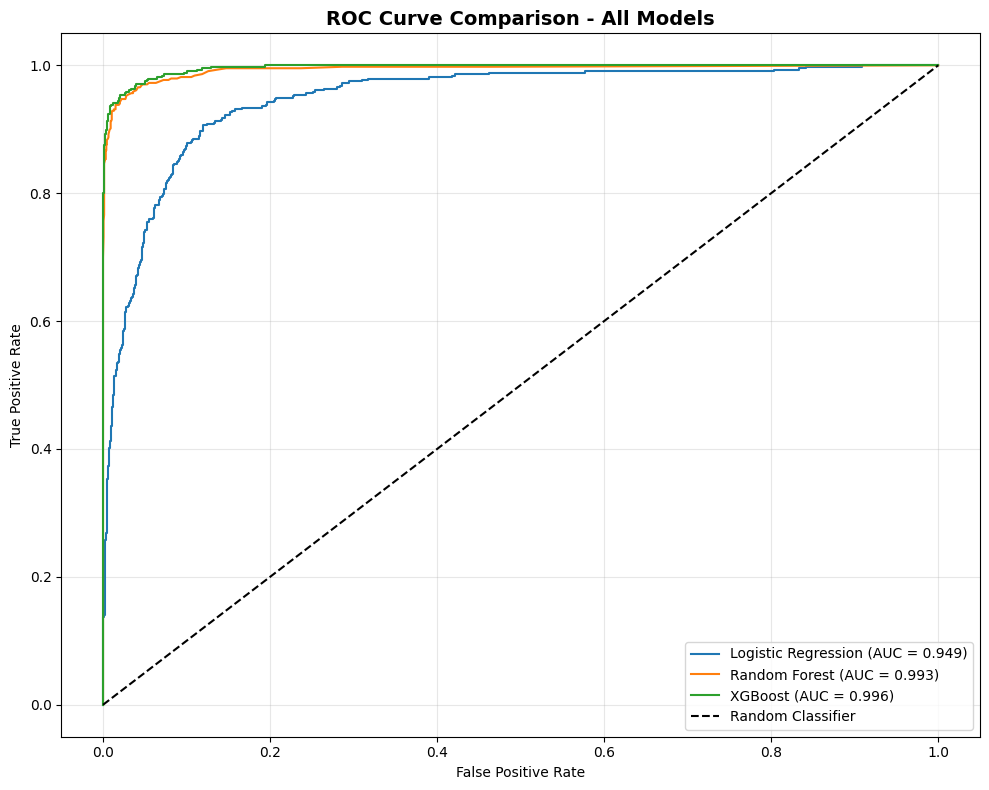

In [25]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Logistic Regression
y_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')

# Random Forest
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')

# XGBoost
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')

# Random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 6.6 Save Best Model

In [26]:
# Save the best performing model (XGBoost typically performs best)
with open('xgboost_fraud_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("Best model saved to: xgboost_fraud_model.pkl")

Best model saved to: xgboost_fraud_model.pkl


## 7. Summary and Conclusions

### Key Findings:
1. **Dataset**: 9841 Ethereum transactions with ~22% fraud cases (imbalanced)
2. **Preprocessing**: 
   - Removed categorical features with high cardinality
   - Handled missing values with median imputation
   - Removed zero variance and highly correlated features
   - Applied PowerTransformer for feature scaling
   - Used SMOTE for class imbalance
3. **Models Tested**: Logistic Regression, Random Forest, XGBoost
4. **Best Model**: XGBoost with highest recall for fraud detection

### Next Steps:
1. Create automation script (`automate_MohammadAri.py`)
2. Implement hyperparameter tuning with MLflow
3. Set up CI/CD pipeline
4. Deploy model with monitoring